# Possion Equation


## DGNet

下面尝试利用Gaussian Legendre积分法求积分。

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
from math import pi
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
class Possion1D:
    def __init__(self, N_x:int, N_int:int, deg:int, act:str='tanh') -> None:
        #
        self.name = f'DG_1dpossion_{N_x}_{N_int}_{deg}_{act}'
        #
        self.a = 0.0
        self.b = 1.5
        self.np_dtype = np.float64
        self.torch_dtype = torch.float64
        #
        self.N_x = N_x
        self.N_int = N_int
        self.deg = deg
        #
        self.testfunc = TestFunction1D(func_type='Polynomial')
        #
        self.x, self.xc, self.h, self.Mesh, self.weights = self.get_mesh()
        self.v, self.dv = self.test_data()
        self.model = DGNet(num_modules=self.N_x, input_size=1, hidden_size=20, output_size=1, num_layers=2, act=act).to(device).to(self.torch_dtype)
        # case 1
        # self.f = lambda x: 10 * torch.ones_like(x)
        # case 2
        self.w = 15*pi
        self.f = lambda x: 2 * self.w * torch.sin(self.w * x) + self.w**2 * x * torch.cos(self.w * x)
        self.exact = lambda x: x * torch.cos(self.w * x)
        self.fu = self.f(self.Mesh[:, 1:-1]).squeeze(-1)
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1., max_iter=5000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-6, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe'); self.lfbgsiter = 0
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 70000; self.adamiter = 0

    def test_data(self):
        v_list = []
        dv_list = []
        for i in range(self.deg + 1):
            v, dv = self.testfunc.get_value(x=self.Mesh, x_mid=self.xc[:, None], h=self.h[:, None], order=i)
            v_list.append(v)
            dv_list.append(dv)
        v = torch.stack(v_list, dim=0).to(device)
        dv = torch.stack(dv_list, dim=0).to(device)
        return v, dv

    def get_mesh(self):
        x = np.linspace(self.a, self.b, self.N_x + 1, dtype=self.np_dtype)
        xc = (x[:-1] + x[1:]) / 2.0
        h = (x[1:] - x[:-1]) 
        nodes, weights = np.polynomial.legendre.leggauss(self.N_int)
        mesh = 0.5 * (nodes[None, :] + 1.) * h[:, None] + x[:-1, None]
        weights = 0.5 * weights[None, :] * h[:, None]
        Mesh = np.zeros((self.N_x, self.N_int + 2))
        Mesh[:, 1:-1] = mesh
        Mesh[:, 0] = x[:-1]
        Mesh[:, -1] = x[1:]
        return torch.tensor(x, dtype=self.torch_dtype).to(device), \
               torch.tensor(xc, dtype=self.torch_dtype).to(device), \
               torch.tensor(h, dtype=self.torch_dtype).to(device),\
               torch.tensor(Mesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(weights, dtype=self.torch_dtype).to(device)


    def loss(self):
        Mesh = self.Mesh[..., None].clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        #
        lux = gradu[None, :, 0, 0]; rux = gradu[None, :, -1, 0]
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rux * rv - lux * lv
        #
        flux_u = u[:-1, -1, 0] - u[1:, 0, 0]
        flux_ux = gradu[:-1, -1, 0] - gradu[1:, 0, 0]
        ux = gradu[:, 1:-1, 0]
        # compute local loss
        Int = torch.sum((ux[None, ...] * self.dv[:, :, 1:-1] - self.fu[None, ...] * self.v[:, :, 1:-1]) * self.weights[None, ...], dim=-1) - bd # [deg + 1, N_x]
        local_loss = torch.sum(Int**2)
        # compute boundary loss
        bd_loss = (u[0, 0, 0]**2 + u[-1, -1, 0]**2)
        # compute flux loss
        flux_loss = torch.sum((flux_u**2 + flux_ux**2))
        loss = local_loss + bd_loss + flux_loss
        mae = torch.max(abs(u - self.exact(Mesh)))
        mse = torch.mean(abs(u - self.exact(Mesh))**2)
        return loss, mae, mse
    
    def exact_loss(self):
        x = self.Mesh
        u = self.exact(x)
        ux = torch.cos(self.w * x)  - self.w * x * torch.sin(self.w * x)
        lux = ux[None, :, 0]; rux = ux[None, :, -1]
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rux * rv - lux * lv
        #
        flux_u = u[:-1, -1] - u[1:, 0]
        flux_ux = ux[:-1, -1] - ux[1:, 0]
        ux = ux[:, 1:-1]
        # compute local loss
        Int = torch.sum((ux[None, ...] * self.dv[:, :, 1:-1] - self.fu[None, ...] * self.v[:, :, 1:-1]) * self.weights[None, ...], dim=-1) - bd # [deg + 1, N_x]
        local_loss = torch.sum(Int**2)
        # compute boundary loss
        bd_loss = (u[0, 0]**2 + u[-1, -1]**2)
        # compute flux loss
        flux_loss = torch.sum((flux_u**2 + flux_ux**2))
        loss = local_loss + bd_loss + flux_loss
        return loss
    
    def loss_lfbgs(self):
        self.Lfbgs.zero_grad()
        loss, mae, mse = self.loss()
        loss.backward()
        self.writer.add_scalar(f"mse_vs_iter", mse, self.lfbgsiter)
        self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        self.lfbgsiter += 1
        if self.lfbgsiter % 500 == 0:
            print(f"LBFGS At iter: {self.lfbgsiter}, loss_train:{loss.item():.6f}, mae_train:{mae.item():.6f}, mse_train:{mse.item():.6f}")
        return loss
    
    def loss_adam(self):
        self.Adam.zero_grad()
        loss, mae, mse = self.loss()
        self.writer.add_scalar(f"mse_vs_iter", mse, self.lfbgsiter + self.adamiter)
        self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        self.adamiter += 1
        if self.adamiter % 500 == 0:
            print(f"Adam At iter: {self.adamiter}, loss_train:{loss.item():.6f}, mae_train:{mae.item():.6f}, mse_train:{mse.item():.6f}")
        return loss, mae, mse
    def train(self):
        t_start = time.time()
        print('*********** Started training ...... ***************')
        self.t = time.time()
        self.writer = SummaryWriter(f'./logs/possion1d/DGNet')
        self.Lfbgs.step(self.loss_lfbgs)
        torch.save(self.model.state_dict(), f'./models/DGNet/{self.name}.pth')
        loss, mae, mse = self.loss_adam()
        best_loss = mae
        while mae > 1e-6:
            loss.backward()
            self.Adam.step()
            loss, mae, mse = self.loss_adam()
            if mae < best_loss:
                best_loss = mae
                torch.save(self.model.state_dict(), f'./models/DGNet/{self.name}.pth')
            if self.adamiter + self.lfbgsiter > self.maxiter:
                break
        self.adamiter = 0
        self.writer.close()
        print(f'Finished training in {time.time()-t_start:.4f} seconds')
    def load(self):
        path = f'./models/DGNet/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False


### test about the N_int, N_x

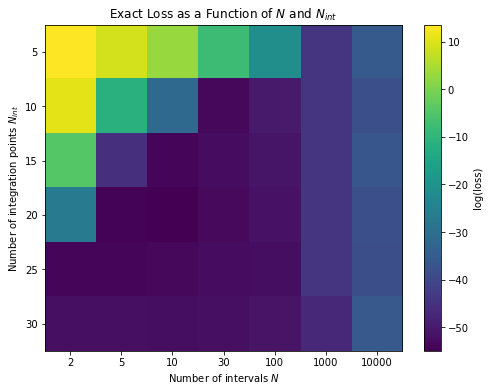

In [33]:
# 定义参数范围
# N_int_values = [15, 20, 30, 40, 50, 60]
# N_x_values = [15, 20, 30, 40, 50, 60]
N_int_values = [5, 10, 15, 20, 25, 30]
N_x_values = [2, 5, 10, 30, 100, 1000, 10000]
N_deg = [3, 5, 10, 20, 40]

# 初始化存储 exact loss 的数组，行对应 N_int, 列对应 N_x
losses = np.zeros((len(N_int_values), len(N_x_values)))

# 遍历参数组合，计算 exact loss
for i, N_int in enumerate(N_int_values):
    for j, N_x in enumerate(N_x_values):
        P = Possion1D(N_x=N_x, N_int=N_int, deg=5)
        losses[i, j] = P.exact_loss()

# 使用 imshow 绘制块状图
plt.figure(figsize=(8, 6))
im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')

plt.colorbar(im, label='log(loss)')

plt.xticks(range(len(N_x_values)), labels=[f"{n}" for n in N_x_values])
plt.yticks(range(len(N_int_values)), labels=[f"{n}" for n in N_int_values])

plt.xlabel(r'Number of intervals $N$')
plt.ylabel(r'Number of integration points $N_{int}$')
plt.title('Exact Loss as a Function of $N$ and $N_{int}$')
# 显示图像
plt.show()

# losses = np.zeros((len(N_deg), len(N_x_values)))

# # 遍历参数组合，计算 exact loss
# for i, deg in enumerate(N_deg):
#     for j, N_x in enumerate(N_x_values):
#         P = Possion1D(N_x=N_x, N_int=15, deg=deg)
#         losses[i, j] = P.exact_loss()

# # 使用 imshow 绘制块状图
# plt.figure(figsize=(8, 6))
# im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')

# plt.colorbar(im, label='log(loss)')

# plt.xticks(range(len(N_x_values)), labels=[f"{n}" for n in N_x_values])
# plt.yticks(range(len(N_deg)), labels=[f"{n}" for n in N_deg])

# plt.xlabel(r'Number of intervals $N_{x}$')
# plt.ylabel(r'Order of test function $p$')
# plt.title('Exact Loss as a Function of $N_{x}$ and $p$')
# # 显示图像
# plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')

plt.colorbar(im, label='log(loss)')

plt.xticks(range(len(N_partitions)), labels=[f"{p:.2f}" for p in N_partitions])
plt.yticks(range(len(N_deg)), labels=[f"{n}" for n in N_deg])

plt.xlabel(r'Partition Size(minimum element size) $s_{min}$')
plt.ylabel(r'Order of test function $p$')
plt.title('Exact Loss as a Function of $p$ and $s_{min}$')
# 显示图像
plt.show()

In [3]:
P = Possion1D(N_x=5, N_int=20, deg=5)
print(P.loss())
print(P.exact_loss())


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(tensor(1737.1642, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>), tensor(11.0891, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>), tensor(30.4880, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>))
tensor(1.2225e-26, device='cuda:0', dtype=torch.float64)


In [39]:
retrain = True
# retrain = False
if retrain:
    P.load()
    P.train()
elif P.load() and not retrain:
    print("train loss: ", P.loss())



Loading saved model...
*********** Started training ...... ***************
LBFGS At iter: 500, loss_train:0.000084, mae_train:0.001374, mse_train:0.000000
LBFGS At iter: 1000, loss_train:0.000077, mae_train:0.001324, mse_train:0.000000
LBFGS At iter: 1500, loss_train:0.000074, mae_train:0.001292, mse_train:0.000000
LBFGS At iter: 2000, loss_train:0.000071, mae_train:0.001269, mse_train:0.000000
LBFGS At iter: 2500, loss_train:0.000070, mae_train:0.001252, mse_train:0.000000
LBFGS At iter: 3000, loss_train:0.000069, mae_train:0.001239, mse_train:0.000000
LBFGS At iter: 3500, loss_train:0.000068, mae_train:0.001230, mse_train:0.000000
LBFGS At iter: 4000, loss_train:0.000067, mae_train:0.001222, mse_train:0.000000
LBFGS At iter: 4500, loss_train:0.000066, mae_train:0.001216, mse_train:0.000000
LBFGS At iter: 5000, loss_train:0.000066, mae_train:0.001211, mse_train:0.000000
LBFGS At iter: 5500, loss_train:0.000066, mae_train:0.001207, mse_train:0.000000
LBFGS At iter: 6000, loss_train:0.0

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10654/1520846663.py", line 5, in <cell line: 3>
    P.train()
  File "/tmp/ipykernel_10654/2172959680.py", line 141, in train
    if mae < best_loss:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/root/anaconda3/l

In [40]:
print(P.loss())

(tensor(1.0891e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>), tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>), tensor(2.3288e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>))


No saved model found. Training the model...
(tensor(1.0891e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>), tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>), tensor(2.3288e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)) tensor(1.2225e-26, device='cuda:0', dtype=torch.float64)


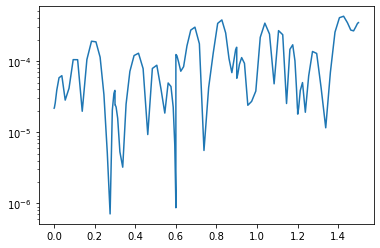

In [41]:
path = f'./models/{P.name}.pth'
if os.path.exists(path):
    print("Loading saved model...")
    model_dict = torch.load(path)
    P.model.load_state_dict(model_dict)
else:
    print("No saved model found. Training the model...")
print(P.loss(), P.exact_loss())
x = P.Mesh
y = P.model(x[..., None])
y = y.cpu().detach().numpy().flatten()
y_exact = P.exact(x)
x = x.cpu().detach().numpy().flatten()
y_exact = y_exact.cpu().detach().numpy().flatten()
err = abs(y-y_exact)
np.savetxt("DGerror.csv", np.column_stack((x, err)), delimiter=",", header="x,err", comments='')

# plt.plot(x, y)
# plt.plot(x, y_exact)
plt.plot(x,err)
plt.yscale('log')
plt.show()

## Here we do the baselines: PINN, DeepRitz, and hpVPINN

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
from math import pi
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Possion1D:
    def __init__(self, method: str='PINN', N_x:int=10, N_int:int=10, deg:int=3, \
                 num_layers:int=2, input_size:int=1, hidden_size:int=50, output_size:int=1, act:str='tanh') -> None:
        #
        self.name = f'1dpossion_{method}_{N_x}_{N_int}_{deg}_{num_layers}_{input_size}_{hidden_size}_{output_size}_{act}'
        #
        self.a = 0.0
        self.b = 1.5
        self.np_dtype = np.float64
        self.torch_dtype = torch.float32
        self.method = method
        #
        self.N_x = N_x
        self.N_int = N_int
        self.deg = deg
        # case 1
        # self.f = lambda x: 10 * torch.ones_like(x)
        # case 2
        self.w = 3 * pi
        self.f = lambda x: 2 * self.w * torch.sin(self.w * x) + self.w**2 * x * torch.cos(self.w * x)
        self.exact = lambda x: x * torch.cos(self.w * x)
        #
        if self.method == "PINN":
            self.mesh = torch.linspace(self.a, self.b, self.N_x + 1, device=device).view(-1, 1)
            self.model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, act=act).to(device).to(self.torch_dtype)
        
        elif self.method == "DeepRitz":
            nodes, weights = np.polynomial.legendre.leggauss(self.N_x)
            h = self.b - self.a
            mesh = 0.5 * (nodes + 1.) * h + self.a
            self.weights = torch.tensor(0.5 * weights * h).to(device)
            self.mesh = torch.tensor(mesh, device=device, dtype=self.torch_dtype).view(-1, 1)
            self.model = ResNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, act=act).to(device).to(self.torch_dtype)
        
        elif self.method == "hpVPINN":
            self.testfunc = TestFunction1D(func_type='Legendre')
            self.x, self.xc, self.h, self.mesh, self.weights = self.get_mesh()
            self.v, self.dv = self.test_data()
            self.model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, act=act).to(device).to(self.torch_dtype)
        
        else:
            raise ValueError(f"Invalid method: {self.method}")
        self.fx = self.f(self.mesh)
        self.exactu = self.exact(self.mesh)

        #
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=20000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-6, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe'); self.lfbgsiter = 0
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 40000; self.adamiter = 0
    
    def loss(self):
        if self.method == 'PINN':
            return self.pinn()
        elif self.method == 'DeepRitz':
            return self.deepritz()
        elif self.method == 'hpVPINN':
            return self.hpvpinn()
        else:
            raise ValueError(f"Invalid method: {self.method}")
        
    def pinn(self):
        self.mesh.requires_grad = True
        u = self.model(self.mesh)
        u_x = torch.autograd.grad(u, self.mesh, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, self.mesh, torch.ones_like(u_x), create_graph=True)[0]
        #
        eq_loss = torch.mean((u_xx + self.fx) ** 2) 
        bd_loss = torch.mean(u[[0, -1], 0] ** 2)
        loss = eq_loss + 10*bd_loss
        mae = torch.max(abs(self.exactu - u))
        mse = torch.mean(abs(self.exactu - u)**2)
        return loss, mae, mse
    
    def deepritz(self):
        self.mesh.requires_grad = True
        u = self.model(self.mesh)
        u_x = torch.autograd.grad(u, self.mesh, torch.ones_like(u), create_graph=True)[0]
        energy = torch.sum((0.5 * u_x**2 - self.fx * u) * self.weights[:, None])
        xb = self.mesh[[0, -1]] 
        output_b = u[[0, -1]] 
        exact_b = self.exact(xb)
        bd_loss = torch.mean((output_b - exact_b)**2)
        loss = energy + 500 * bd_loss
        mae = torch.max(abs(self.exactu - u))
        mse = torch.mean(abs(self.exactu - u)**2)
        return loss, mae, mse
    
    def hpvpinn(self):
        Mesh = self.mesh[..., None].clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        lux = gradu[None, :, 0, 0]; rux = gradu[None, :, -1, 0]
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rux * rv - lux * lv
        #
        ux = gradu[:, 1:-1, 0]
        # compute local loss
        Int = torch.sum((ux[None, ...] * self.dv[:, :, 1:-1] - self.fx[None, :, 1:-1] * self.v[:, :, 1:-1]) * self.weights[None, ...], dim=-1) - bd # [deg + 1, N_x]
        local_loss = torch.sum(Int**2)
        # compute boundary loss
        bd_loss = (u[0, 0, 0]**2 + u[-1, -1, 0]**2)
        loss = local_loss + 100*bd_loss
        mae = torch.max(abs(u - self.exact(Mesh)))
        mse = torch.mean(abs(u - self.exact(Mesh))**2)
        return loss, mae, mse
    
    def train(self):
        print('*********** Started training ...... ***************')
        t = time.time()
        self.writer = SummaryWriter(f'./logs/possion1d/{self.method}')
        loss, mae, mse = self.loss()
        best_loss = loss
        epoch = 0
        # while  mse.item() > 1e-3:
        while  epoch < self.maxiter:
            self.Adam.zero_grad()
            loss, mae, mse = self.loss()
            self.writer.add_scalar(f"mse_vs_iter", mse, epoch)
            self.writer.add_scalar(f"mse_vs_time", mse, time.time() - t)
            loss.backward()
            self.Adam.step()
            epoch += 1
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/{self.method}/{self.name}.pth')
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, mse = {mse.item():.6f}, mae = {mae.item():.6f}")
            # if epoch > self.maxiter:
            #     break
            # if mae.item() < 1e-4:
            #     print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Exact Loss = {mse.item():.6f}")
            #     break
        self.writer.close()
        print(f'Finished training in {time.time()-t:.4f} seconds')
    def load(self):
        path = f'./models/{self.method}/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False
    
    def test_data(self):
        v_list = []
        dv_list = []
        for i in range(self.deg + 1):
            v, dv = self.testfunc.get_value(x=self.mesh, x_mid=self.xc[:, None], h=self.h[:, None], order=i)
            v_list.append(v)
            dv_list.append(dv)
        v = torch.stack(v_list, dim=0).to(device)
        dv = torch.stack(dv_list, dim=0).to(device)
        return v, dv

    def get_mesh(self):
        x = np.linspace(self.a, self.b, self.N_x + 1, dtype=self.np_dtype)
        xc = (x[:-1] + x[1:]) / 2.0
        h = (x[1:] - x[:-1]) 
        nodes, weights = np.polynomial.legendre.leggauss(self.N_int)
        mesh = 0.5 * (nodes[None, :] + 1.) * h[:, None] + x[:-1, None]
        weights = 0.5 * weights[None, :] * h[:, None]
        Mesh = np.zeros((self.N_x, self.N_int + 2))
        Mesh[:, 1:-1] = mesh
        Mesh[:, 0] = x[:-1]
        Mesh[:, -1] = x[1:]
        return torch.tensor(x, dtype=self.torch_dtype).to(device), \
               torch.tensor(xc, dtype=self.torch_dtype).to(device), \
               torch.tensor(h, dtype=self.torch_dtype).to(device),\
               torch.tensor(Mesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(weights, dtype=self.torch_dtype).to(device)




### train

In [44]:
P = Possion1D(method='PINN', N_x=10000, N_int=30, num_layers=3, hidden_size=40, deg=3, act='tanh')
P.train()

*********** Started training ...... ***************


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 100: Loss = 3198.596680, mse = 0.336915, mae = 1.161096
Epoch 200: Loss = 3192.238281, mse = 0.350054, mae = 1.217431
Epoch 300: Loss = 3178.068848, mse = 0.389990, mae = 1.233157
Epoch 400: Loss = 3115.321533, mse = 0.450762, mae = 1.262747
Epoch 500: Loss = 2567.757080, mse = 0.669282, mae = 1.855464
Epoch 600: Loss = 1452.561401, mse = 1.174881, mae = 2.725711
Epoch 700: Loss = 1006.730469, mse = 2.643869, mae = 3.043758
Epoch 800: Loss = 877.860657, mse = 2.172504, mae = 2.638177
Epoch 900: Loss = 758.327698, mse = 1.192717, mae = 1.925867
Epoch 1000: Loss = 573.936096, mse = 0.989134, mae = 1.554832
Epoch 1100: Loss = 387.706665, mse = 1.461722, mae = 2.115750
Epoch 1200: Loss = 326.449921, mse = 1.937840, mae = 2.402537
Epoch 1300: Loss = 307.234375, mse = 2.143224, mae = 2.496244
Epoch 1400: Loss = 295.927002, mse = 2.208135, mae = 2.519856
Epoch 1500: Loss = 287.557892, mse = 2.202304, mae = 2.513197
Epoch 1600: Loss = 280.023224, mse = 2.177246, mae = 2.498209
Epoch 1700

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10654/3673320067.py", line 2, in <cell line: 2>
    P.train()
  File "/tmp/ipykernel_10654/1755049000.py", line 132, in train
    loss, mae, mse = self.loss()
  File "/tmp/ipykernel_10654/1755049000.py", line 68, in loss
    return self.pinn()
  File "/tmp/ipykernel_10654/1755049000.py", line 78, in pinn
    u = self.model(self.mesh)
  File "/root/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/data/update_dg/zzzupdate/utilities.py", line 276, in forward
    x = self.activation(layer(x))
  File "/root/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/root/anaconda3/lib/python3.9

### load

Loading saved model...
(tensor(-25.3696, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.0282, device='cuda:0', grad_fn=<MaxBackward1>), tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>))


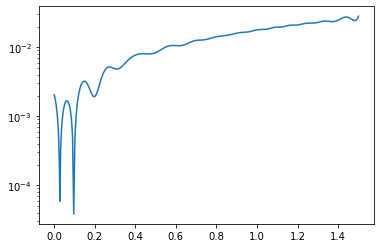

In [20]:
# P = Possion1D(method='DeepRitz', N_x=200, N_int=20, num_layers=6, hidden_size=40, deg=3, act='tanh')
# P = Possion1D(method='PINN', N_x=10000, N_int=20, num_layers=6, hidden_size=40, deg=3, act='tanh')
P.load()
print(P.loss())
x = P.mesh
y = P.model(x[..., None])
y = y.cpu().detach().numpy().flatten()
y_exact = P.exact(x)
x = x.cpu().detach().numpy().flatten()
y_exact = y_exact.cpu().detach().numpy().flatten()
err = abs(y-y_exact)
np.savetxt(f"./{P.method}_error.csv", np.column_stack((x, err)), delimiter=",", header="x,err", comments='')

plt.plot(x,err)
# plt.plot(x, y)
# plt.plot(x, y_exact)
plt.yscale('log')
plt.show()

In [ ]:
# def plot_loss_vs_Nx_Nint():
#     N_x_values = range(10, 40, 1)  # 设置N_x的取值范围
#     Nint_values = range(20, 50, 1)  # 设置Nint_x的取值范围
#     losses = np.zeros((len(N_x_values), len(Nint_values)))  # 用于存储每对(N_x, Nint_x)的loss值
#     deg = 6
#     # 计算每一组 N_x 和 Nint_x 对应的loss
#     for i, N_x in enumerate(N_x_values):
#         for j, Nint_x in enumerate(Nint_values):
#             p = Possion1D(N_x=N_x, N_int=Nint_x, deg=deg)  # 创建Possion对象
#             loss = p.exact_loss()  # 计算loss
#             loss = loss.cpu().numpy()  # 如果loss是tensor，转为numpy
#             losses[i, j] = loss  # 存储到对应的位置
#             del p

#     # 绘制loss关于N_x和Nint_x的图
#     X, Y = np.meshgrid(Nint_values, N_x_values)  # 创建网格
#     fig = plt.figure(figsize=(8, 6))
#     cp = plt.contourf(X, Y, losses, levels=20, cmap='jet')  # 使用contourf绘制填充轮廓图
#     fig.colorbar(cp, label='Loss')  # 添加颜色条
#     plt.xlabel('Nint_x')
#     plt.ylabel('N_x')
#     plt.title(f'Loss as a function of N_x and Nint_x, deg={deg}')
#     plt.grid(True)
#     plt.show()

# # 调用函数绘图
# plot_loss_vs_Nx_Nint()